Churn prediction problem
The following document contains the step by step analysis and prediction of churn probability for users for the upcoming marketing campaign for churn prediction. The document contains the following broad areas

1.Obtain the data

2.Analysing the data to create a labelled data set

3.Exploratory analysis of the data to understand features and their importance

4.Training multiple models and then using the best one to predict churn probability based on model performance

5.Using the model to predict churn for active users of Q4-2016

6.Saving the final prediction and some business inputs

7.Storing the model as pickles and reloading them to do prediction independent of the other analysis

In [490]:
import pandas as pd
from itertools import chain
from tqdm import tqdm
import numpy as np
from datetime import datetime
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [43]:
df_creditors=pd.read_csv("creditors.csv")
df_mandates = pd.read_csv("mandates.csv")
df_payments = pd.read_csv("payments.csv")

In [44]:
## Some basic sanity checks for the 3 data frame 
def nulldata(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending = False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()*100).sort_values(ascending = False)
    df_null=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return(df_null)

print(nulldata(df_creditors))
print(nulldata(df_mandates))
print(nulldata(df_payments))

                 Total    Percent
country_code       845  11.456074
merchant_type       65   0.881236
id                   0   0.000000
created_at           0   0.000000
has_logo             0   0.000000
refunds_enabled      0   0.000000
                           Total  Percent
id                             0      0.0
created_at                     0      0.0
creditor_id                    0      0.0
scheme                         0      0.0
payments_require_approval      0      0.0
is_business_customer_type      0      0.0
                 Total  Percent
Unnamed: 0           0      0.0
id                   0      0.0
created_at           0      0.0
mandate_id           0      0.0
creditor_id          0      0.0
amount_gbp           0      0.0
source               0      0.0
has_description      0      0.0
has_reference        0      0.0


We could see the data is fairly populated with only country code and merchant type having few null values
Hence we proceed towards some exploratory analysis of the data

In [45]:
# Perform few basic exploratory checks

print('Total no of creditors '+str(len(df_creditors.id.unique())))
print('Total no of creditors with mandates '+str(len(df_mandates.creditor_id.unique())))
print('Total no of creditors with atleast one transaction last year '+str(len(df_payments.creditor_id.unique())))


Total no of creditors 7376
Total no of creditors with mandates 6755
Total no of creditors with atleast one transaction last year 6353


We can see that of the 7376 users 6353 users were active last year and the rest 1023 haven't done any transactions. Based on the problem statement we also know that we need to focus on users who were active in 2016Q4. Hence we scale the probability of churn to the users who were active atleast in one of the months of 2016Q4

In [46]:
df_payments['month']=df_payments.apply(lambda row:datetime.strptime(row["created_at"][:10],"%Y-%m-%d").month,axis=1)
df_payments['date_of_mon']=df_payments.apply(lambda row:datetime.strptime(row["created_at"][:10],"%Y-%m-%d").strftime("%Y-%m-%d"),axis=1)
user_active_q4=df_payments[df_payments.month>=10].creditor_id.unique()
print('Total no of users who were active on 2016Q4 are '+str(len(user_active_q4)))

Total no of users who were active on 2016Q4 are 4268


In [47]:
df_creditors['month']=df_creditors.apply(lambda row:datetime.strptime(row["created_at"][:10],"%Y-%m-%d").month,axis=1)
df_creditors['date_of_mon']=df_creditors.apply(lambda row:datetime.strptime(row["created_at"][:10],"%Y-%m-%d").strftime("%Y-%m-%d"),axis=1)

In [108]:
df_mandates.groupby(["creditor_id","is_business_customer_type"])["id"].count()

creditor_id       is_business_customer_type
000272d8d04f3ed2  False                          1
000c22bf511987ff  False                          5
000dcdef6d4373fd  False                         12
00337e15ad545f99  True                           3
0035ef68cf8c1a7e  False                          7
                                              ... 
ffcbd2e29846feb6  False                          3
                  True                         113
ffdb6e5fd5cb6dd1  False                         44
                  True                          41
ffdd0f33d33cbb8a  False                          1
Name: id, Length: 8901, dtype: int64

In [106]:
df_mandates.head()

,id,created_at,creditor_id,scheme,payments_require_approval,is_business_customer_type
0,48bd8ece0e8b3cce,2016-08-04 10:02:33.753039 UTC,000272d8d04f3ed2,bacs,True,False
1,82464146cf7fb83a,2016-07-26 06:18:06.422498 UTC,000c22bf511987ff,bacs,False,False
2,0ea8942e42390cac,2016-09-12 11:21:53.023428 UTC,000c22bf511987ff,bacs,False,False
3,859c70bb8de7f063,2016-07-25 17:07:19.626298 UTC,000c22bf511987ff,bacs,False,False
4,bc678786559c8f04,2016-07-07 16:19:01.310005 UTC,000c22bf511987ff,bacs,False,False


In [49]:
len(set(list(user_active_q4)).intersection(set(list(df_creditors[df_creditors.month>=10]["id"]))))

1061

In [50]:
df_payments[(df_payments.creditor_id=="a42a1416c0e3e6af")&(df_payments.month==1)]

,Unnamed: 0,id,created_at,mandate_id,creditor_id,amount_gbp,source,has_description,has_reference,month,date_of_mon
194550,194550,03b81ec1de86efed,2016-01-27 11:15:38.641576+00:00,a4111327c3fa87d8,a42a1416c0e3e6af,137.62,dashboard,True,False,1,2016-01-27
194552,194552,364c2f79532a26af,2016-01-27 11:43:39.932483+00:00,2777aa394bc8f558,a42a1416c0e3e6af,146.44,dashboard,True,False,1,2016-01-27
194567,194567,40ff6b91f52db5e1,2016-01-27 11:23:14.433191+00:00,2e206489134b151d,a42a1416c0e3e6af,101.20,dashboard,True,False,1,2016-01-27


In [158]:
def missed_activity(txn_list,month_list):
    all_months = set(month_list)
    missing_month = set(all_months)-set([val[0] for val in txn_list])
    missing_activity_list = []
    for month in missing_month:
        data_tuple = (month,0,0,0)
        missing_activity_list.append(data_tuple)

    return (missing_activity_list)

class Activity:
    
    def __init__(self,payment_data,creditor_data,creditor_id):
        self.creditor_id = creditor_id
        self.merchant_type = creditor_data[creditor_data.id==creditor_id]["merchant_type"].values[0]
        self.country = creditor_data[creditor_data.id==creditor_id]["country_code"].values[0]
        self.has_logo = creditor_data[creditor_data.id==creditor_id]["has_logo"].values[0]
        self.payment_data = payment_data[payment_data.creditor_id==self.creditor_id].reset_index(drop=True)
        self.creditor_created_data = creditor_data[creditor_data.id==self.creditor_id]["date_of_mon"]
        self.payment_months = sorted(list(payment_data[payment_data.creditor_id==self.creditor_id]["month"].unique()))
        self.last_activity = max(self.payment_months) if len(self.payment_months)>0 else 0
        self.first_activity = min(self.payment_months) if len(self.payment_months)>0 else 0
        self.txn_amts_avg, self.txn_cnts = self.txn_amount()
        self.active_mnth = [1 for val in self.txn_amts_avg if val>0]
        self.creditor_detail = list(zip(self.payment_months,self.txn_amts_avg,self.txn_cnts,self.active_mnth))
        self.sample_detail = self.churn_label()
        self.sample_txn = self.get_txn_data()
        
    def txn_amount(self):
        
        txn_amts = self.payment_data.groupby(["month"])["amount_gbp"].sum()
        txn_cnts = list(self.payment_data.groupby(["month"])["amount_gbp"].count())
        txn_avg = [x/y for x,y in zip(txn_amts,txn_cnts)]
        
        return (txn_avg,txn_cnts)
    
    def churn_label(self):
        
        trn_activity_month = set([1, 2,3, 4, 5, 6])
        trn_activity_outcome_month = set([7,8,9])
        tst_activity_month = set([4,5,6,7,8,9])
        tst_activity_outcome_month = set([10,11,12])
        
        
        if len(set(trn_activity_month).intersection(set([val[0] for val in self.creditor_detail])))>0:
            trn_sample = 1
            if len(set(trn_activity_outcome_month).intersection(set([val[0] for val in self.creditor_detail])))>0:
                trn_label=1
            else:
                trn_label=0
        else:
            trn_sample = 0
            trn_label = 0
        
        
        if len(set(tst_activity_month).intersection(set([val[0] for val in self.creditor_detail])))>0:
            tst_sample=1
            if len(set(tst_activity_outcome_month).intersection(set([val[0] for val in self.creditor_detail])))>0:
                tst_label=1
            else:
                tst_label=0
        else:
            tst_sample=0
            tst_label=0
        
        
        return (trn_sample,trn_label,tst_sample,tst_label)
    
    def get_txn_data(self):
        
        if self.sample_detail[0]==1:
            trn_txn_details= [val for val in self.creditor_detail if val[0]<=6]
            txn_missing = missed_activity(trn_txn_details,[1,2,3,4,5,6])
            trn_txn_details=sorted(list(chain(trn_txn_details, txn_missing)))
        else:
            trn_txn_details=[]
            
        if self.sample_detail[2]==1:
            tst_txn_details = [val for val in self.creditor_detail if (val[0]<=9) and (val[0]>3)]
            txn_missing= missed_activity(tst_txn_details,[4,5,6,7,8,9])
            tst_txn_details=sorted(list(chain(tst_txn_details, txn_missing)))
        else:
            tst_txn_details=[]
            
        return (trn_txn_details,tst_txn_details)
    
    def pred_data(self):
        
        pred_month = [10,11,12]
        if len(set(pred_month).intersection(set([val[0] for val in self.creditor_detail])))>0:
            pred_txn_details= [val for val in self.creditor_detail if val[0]>=7]
            pred_missing = missed_activity(pred_txn_details,[7,8,9,10,11,12])
            pred_txn_details=sorted(list(chain(pred_txn_details, pred_missing)))
        else:
            pred_txn_details=[]
            
        return (pred_txn_details)
            

In [174]:
all_creditor_details = []
all_data=[]
for creditor in tqdm(df_creditors.id.unique()):
    cred_details = Activity(df_payments,df_creditors,creditor)
    temp_data_dict = {"creditor_id":cred_details.creditor_id,
            "train_label":cred_details.sample_detail[1],
        "train_data":cred_details.sample_txn[0],
        "test_label":cred_details.sample_detail[3],
        "test_data":cred_details.sample_txn[1],
         "business_type":cred_details.merchant_type,
            "country": cred_details.country,
         "has_logo":cred_details.has_logo}
    all_creditor_details.append(cred_details)
    
    all_data.append(temp_data_dict)

100%|██████████| 7376/7376 [04:04<00:00, 30.14it/s]


In [175]:
df_all_data = pd.DataFrame(all_data)
df_all_data["train_suitable"]=df_all_data.apply(lambda row:1 if len(row.train_data)>0 else 0,axis=1)
df_all_data["test_suitable"]=df_all_data.apply(lambda row:1 if len(row.test_data)>0 else 0,axis=1)

In [176]:
df_all_data.to_pickle("df_all_data.pickle")

In [177]:
df_all_data=pd.read_pickle("df_all_data.pickle")

In [178]:
df_all_data[df_all_data.test_suitable==1].groupby("test_label").count()

,creditor_id,train_label,train_data,test_data,business_type,country,has_logo,train_suitable,test_suitable
test_label,,,,,,,,,
0,1529,1529,1529,1529,1494,1316,1529,1529,1529
1,3318,3318,3318,3318,3310,2889,3318,3318,3318


In [487]:
len(df_all_data)

7376

In [182]:
df_train_suitable = df_all_data[df_all_data.train_suitable==1].reset_index(drop=True)
df_train_suitable["train_array"]=df_train_suitable.apply(lambda row:np.array([val[1:] for val in row.train_data]),axis=1)

In [183]:
df_train_suitable.head()

,creditor_id,train_label,train_data,test_label,test_data,business_type,country,has_logo,train_suitable,test_suitable,train_array
0,1ede401acc3efb19,1,"[(1, 23.91, 1, 1), (2, 22.18857142857143, 7, 1...",1,"[(4, 37.636842105263156, 19, 1), (5, 26.599999...",NaN,NaN,False,1,1,"[[23.91, 1.0, 1.0], [22.18857142857143, 7.0, 1..."
1,18f20c90246ab02f,1,"[(1, 17.076315789473682, 19, 1), (2, 15.896315...",1,"[(4, 16.49838709677419, 62, 1), (5, 15.8163768...",NaN,NaN,False,1,1,"[[17.076315789473682, 19.0, 1.0], [15.89631578..."
2,89d2d104c18cb5f8,1,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 0), (4,...",0,"[(4, 0, 0, 0), (5, 0, 0, 0), (6, 91.7904687500...",NaN,NaN,False,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
3,c75c6bb958723b7e,1,"[(1, 20.61, 1, 1), (2, 33.89666666666667, 6, 1...",1,"[(4, 30.468, 5, 1), (5, 39.5, 10, 1), (6, 26.4...",NaN,NaN,False,1,1,"[[20.61, 1.0, 1.0], [33.89666666666667, 6.0, 1..."
4,19d9a3329f2680fd,0,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 0), (4,...",0,"[(4, 0, 0, 0), (5, 0, 0, 0), (6, 14.21, 1, 1),...",NaN,NaN,False,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."


/home/tdhar/src/am_combiner/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tdhar/src/am_combiner/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Density plot by total amount of transaction')

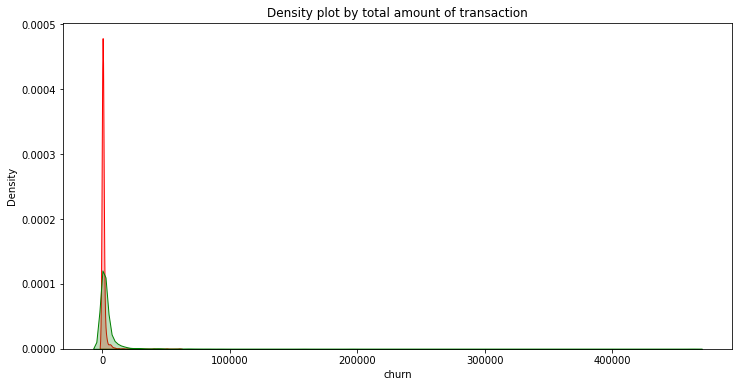

In [184]:
churn = df_train_suitable[df_train_suitable["train_label"] == 0]
non_churn = df_train_suitable[df_train_suitable["train_label"] == 1]
churn["churn"] = churn.apply(lambda row: sum([val[1]*val[2] for val in row.train_data]),axis=1)
non_churn["non_churn"] = non_churn.apply(lambda row: sum([val[1]*val[2] for val in row.train_data]),axis=1)
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by total amount of transaction')

/home/tdhar/src/am_combiner/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tdhar/src/am_combiner/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Density plot by no of distinct transaction month')

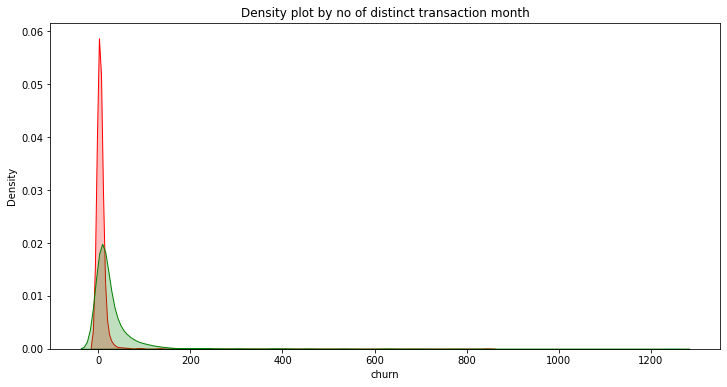

In [185]:
churn = df_train_suitable[df_train_suitable["train_label"] == 0]
non_churn = df_train_suitable[df_train_suitable["train_label"] == 1]
churn["churn"] = churn.apply(lambda row: sum([val[2] for val in row.train_data]),axis=1)
non_churn["non_churn"] = non_churn.apply(lambda row: sum([val[2] for val in row.train_data]),axis=1)
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by no of distinct transaction month')

In [244]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train_suitable, test_size=0.2)

In [361]:
train=train.reset_index(drop=True).fillna("unknown")
df_woe_iv = (pd.crosstab(train["business_type"],test[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))
df_woe_iv=df_woe_iv.reset_index()

In [364]:
train=pd.merge(train,df_woe_iv,how="inner",on="business_type")
test = pd.merge(test,df_woe_iv,how="inner",on="business_type")


In [365]:
x_train=torch.stack([torch.Tensor(val)for val in np.array(train.train_array.values)])
x_biz_woe_train = torch.Tensor(train.woe.values)
y_train = torch.Tensor(train.train_label.values)
x_test = torch.stack([torch.Tensor(val)for val in np.array(test.train_array.values)])
x_biz_woe_test = torch.Tensor(test.woe.values)
y_test=torch.Tensor(test.train_label.values)

In [491]:
x_train[0]

tensor([[23.9100,  1.0000,  1.0000],
        [22.1886,  7.0000,  1.0000],
        [20.6447, 15.0000,  1.0000],
        [37.6368, 19.0000,  1.0000],
        [26.6000, 10.0000,  1.0000],
        [33.7471,  7.0000,  1.0000]])

In [276]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        
        #Constructor
        super().__init__()          
        
        #lstm layer
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=n_layers)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, train_seq):
        
        packed_output, (hidden, cell) = self.lstm(train_seq.reshape(6,1,3))
                    
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [270]:
model = classifier(input_dim=3,hidden_dim=10,output_dim=1,n_layers=1)
print(model)

classifier(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (act): Sigmoid()
)


In [ ]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


In [271]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
train_iterator = list(zip(x_train,y_train))
valid_iterator = list(zip(x_test,y_test))

In [ ]:
def train(model, iterator, optimizer, criterion):
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for x,y in iterator:

        optimizer.zero_grad() 

        predictions = model(x).squeeze() 

        #compute the loss
        loss = criterion(predictions, y)        

        loss.backward()       

        #update the weights
        optimizer.step()      

        #loss and accuracy
        epoch_loss += loss.item()  

    return epoch_loss
    
    

In [ ]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for x,y in iterator:
        
           
            predictions = model(x).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, y)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
        
    return epoch_loss

In [ ]:
best_valid_loss = float('inf')
for epoch in range(10):
     
    #train the model
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        torch.save(model.state_dict(), "test_lstm_v2.torch")
    
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    
    

In [19]:
df_test_suitable = df_all_data[df_all_data.test_suitable==1].reset_index(drop=True)
df_test_suitable["test_array"]=df_test_suitable.apply(lambda row:np.array([val[0:] for val in row.test_data]),axis=1)

In [20]:
df_test_suitable.test_array[0]

array([[ 4.        , 37.63684211, 19.        ,  1.        ],
       [ 5.        , 26.6       , 10.        ,  1.        ],
       [ 6.        , 33.74714286,  7.        ,  1.        ],
       [ 7.        , 28.58333333,  9.        ,  1.        ],
       [ 8.        , 37.47071429, 14.        ,  1.        ],
       [ 9.        , 24.65083333, 12.        ,  1.        ]])

In [21]:
x_eval=torch.stack([torch.Tensor(val)for val in np.array(df_test_suitable.test_array.values)])
y_eval = torch.Tensor(df_test_suitable.test_label.values)

In [62]:
pred_model = classifier(input_dim=3,hidden_dim=10,output_dim=1,n_layers=1)
pred_model.load_state_dict(torch.load("test_lstm_v2.torch"))
    

<All keys matched successfully>

In [30]:
pred_model.parameters

<bound method Module.parameters of classifier(
  (lstm): LSTM(4, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (act): Sigmoid()
)>

In [31]:
def predict(model,iterator):
    
    all_predictions = []
    for x in iterator:
        
        predictions = model(x).squeeze()
        
        all_predictions.append(predictions)
        
    return (all_predictions)

In [32]:
all_predictions = predict(pred_model,x_eval)

In [ ]:
all_predictions[0]

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [34]:
conf_mat=confusion_matrix(y_eval.numpy(), np.array([1 if val>0.5 else 0 for val in all_predictions]))
print(conf_mat)

[[1253  276]
 [ 486 2832]]


In [35]:
precision_recall_fscore_support(y_eval.numpy(), np.array([1 if val>0.5 else 0 for val in all_predictions]), average='macro')

(0.8158629754374436, 0.8365080416350792, 0.8241245498607439, None)

In [36]:
tn, fp, fn, tp = confusion_matrix(y_eval.numpy(), np.array([1 if val>0.5 else 0 for val in all_predictions])).ravel()

In [37]:
print(tn,fp,fn,tp)

1253 276 486 2832


In [52]:
all_pred_txn=[]
for creditor in tqdm(df_creditors.id.unique()):
    cred_details = Activity(df_payments,df_creditors,creditor)
    all_pred_txn.append(cred_details.pred_data())

100%|██████████| 7376/7376 [03:41<00:00, 33.24it/s]


In [ ]:
cred_details.pred_data()

In [ ]:
[txn[1:] for txn in pred_vals[0]]

In [53]:
pred_vals = [val for val in all_pred_txn if len(val)>0]

pred_values=[]
for val in pred_vals:
    new_array=[txn[1:] for txn in val]
    pred_values.append(new_array)

In [54]:
pred_vals[0]

pred_values[0]

[(28.583333333333332, 9, 1),
 (37.47071428571429, 14, 1),
 (24.650833333333335, 12, 1),
 (40.105384615384615, 13, 1),
 (21.128, 5, 1),
 (43.721999999999994, 10, 1)]

In [63]:
pred_tensor=torch.stack([torch.Tensor(val)for val in pred_values])

In [64]:
final_predictions = predict(pred_model,pred_tensor)

In [480]:
sum([1 if val>0.5 else 0 for val in final_predictions])-len(final_predictions)

-696

In [68]:
final_predictions

[tensor(0.9919, grad_fn=<SqueezeBackward0>),
 tensor(0.9837, grad_fn=<SqueezeBackward0>),
 tensor(0.9833, grad_fn=<SqueezeBackward0>),
 tensor(0.9928, grad_fn=<SqueezeBackward0>),
 tensor(0.3244, grad_fn=<SqueezeBackward0>),
 tensor(0.2245, grad_fn=<SqueezeBackward0>),
 tensor(0.6193, grad_fn=<SqueezeBackward0>),
 tensor(0.3166, grad_fn=<SqueezeBackward0>),
 tensor(0.5695, grad_fn=<SqueezeBackward0>),
 tensor(0.6176, grad_fn=<SqueezeBackward0>),
 tensor(0.4414, grad_fn=<SqueezeBackward0>),
 tensor(0.5404, grad_fn=<SqueezeBackward0>),
 tensor(0.9740, grad_fn=<SqueezeBackward0>),
 tensor(0.9491, grad_fn=<SqueezeBackward0>),
 tensor(0.8989, grad_fn=<SqueezeBackward0>),
 tensor(0.9881, grad_fn=<SqueezeBackward0>),
 tensor(0.9722, grad_fn=<SqueezeBackward0>),
 tensor(0.9901, grad_fn=<SqueezeBackward0>),
 tensor(0.6181, grad_fn=<SqueezeBackward0>),
 tensor(0.9849, grad_fn=<SqueezeBackward0>),
 tensor(0.9925, grad_fn=<SqueezeBackward0>),
 tensor(0.9934, grad_fn=<SqueezeBackward0>),
 tensor(0.

In [110]:
cred_details

In [83]:
final_predictions[9]

tensor(0.6176, grad_fn=<SqueezeBackward0>)

In [137]:
# The function to calculate information value
def calc_iv(df, feature, target):

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE_'+str(feature)] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV_'+str(feature)] = (data['WoE_'+str(feature)] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)
    
    data=data[['Variable', 'Value','WoE_'+str(feature),'IV_'+str(feature)]]
    data.replace([np.inf, -np.inf], 1,inplace=True)

 
    return (data)

In [241]:
train

,creditor_id,train_label,train_data,test_label,test_data,business_type,country,has_logo,train_suitable,test_suitable,train_array
957,bd03b9ea7d9c796a,0,"[(1, 0, 0, 0), (2, 3356.49, 1, 1), (3, 0, 0, 0...",0,[],business,GB,False,1,0,"[[0.0, 0.0, 0.0], [3356.49, 1.0, 1.0], [0.0, 0..."
4028,e8da82cb320618ad,1,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 0), (4,...",1,"[(4, 0, 0, 0), (5, 0, 0, 0), (6, 460.95, 2, 1)...",business,GB,True,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
3628,aae70f129ffe745b,1,"[(1, 84.22, 2, 1), (2, 0, 0, 0), (3, 63.879999...",0,"[(4, 63.06333333333333, 6, 1), (5, 80.48, 1, 1...",business,GB,True,1,1,"[[84.22, 2.0, 1.0], [0.0, 0.0, 0.0], [63.87999..."
1038,62ccbe4ba732e704,0,"[(1, 0, 0, 0), (2, 6834.34, 1, 1), (3, 0, 0, 0...",0,[],business,GB,False,1,0,"[[0.0, 0.0, 0.0], [6834.34, 1.0, 1.0], [0.0, 0..."
2609,4d76eccbba2c6a4e,1,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 54.31, 2, 1),...",1,"[(4, 65.16499999999999, 2, 1), (5, 0, 0, 0), (...",individual,GB,False,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [54.31, 2.0..."
...,...,...,...,...,...,...,...,...,...,...,...
4089,698b471400dff512,1,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 0), (4,...",1,"[(4, 20.2, 2, 1), (5, 16.88, 3, 1), (6, 70.642...",business,GB,True,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
900,c1a913d96b9c7d33,0,"[(1, 4.35, 1, 1), (2, 5.76, 1, 1), (3, 6.63, 1...",0,"[(4, 5.36, 1, 1), (5, 4.38, 1, 1), (6, 5.03, 1...",business,GB,False,1,1,"[[4.35, 1.0, 1.0], [5.76, 1.0, 1.0], [6.63, 1...."
4275,677a871a233079fa,1,"[(1, 11.134166666666665, 12, 1), (2, 14.75625,...",1,"[(4, 9.4435, 20, 1), (5, 11.069374999999999, 1...",individual,GB,True,1,1,"[[11.134166666666665, 12.0, 1.0], [14.75625, 1..."
678,5ca3c2b1bd8400cd,1,"[(1, 51.342727272727274, 11, 1), (2, 27.952, 1...",0,"[(4, 54.00375, 8, 1), (5, 31.14375, 8, 1), (6,...",business,GB,False,1,1,"[[51.342727272727274, 11.0, 1.0], [27.952, 15...."


In [214]:
merchant_crosstab=pd.crosstab(test['country'], test['train_label'], margins=True, normalize=False)
new_index = {1: 'Not-Churned', 0: 'Churned', }
merchant_crosstab.rename(index=new_index,inplace=True)

In [215]:
merchant_crosstab

train_label,0,1,All
country,,,
BE,3,0,3
DE,5,4,9
DK,0,1,1
ES,10,6,16
FR,23,32,55
GB,1261,2564,3825
IE,12,11,23
IT,1,0,1
LU,1,0,1


In [267]:
train=train.reset_index(drop=True).fillna("unknown")
df_woe_iv = (pd.crosstab(train["business_type"],test[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

In [268]:
df_woe_iv

train_label,0,1,woe,iv
business_type,,,,
business,0.432990,0.632075,0.378295,0.204647
charity,0.134021,0.138365,0.031900,0.204647
individual,0.426117,0.226415,-0.632344,0.204647
unknown,0.006873,0.003145,-0.781875,0.204647


In [279]:
lstm = nn.LSTM(3, 
                           10, 
                           num_layers=1)
packed_output, (hidden, cell) = lstm(train_iterator[0][0].reshape(6,1,3))

AttributeError: 'Tensor' object has no attribute 'np'

In [293]:
torch.cat((hidden,torch.Tensor([[[1.0]]])),dim=1)

RuntimeError: Sizes of tensors must match except in dimension 1. Got 10 and 1 in dimension 2 (The offending index is 1)

In [306]:
torch.cat((hidden,hidden),dim=1)

tensor([[[ 0.3089,  0.0484,  0.0026,  0.0063, -0.0540,  0.8817,  0.9980,
          -0.7641, -0.0314,  0.1828],
         [ 0.3089,  0.0484,  0.0026,  0.0063, -0.0540,  0.8817,  0.9980,
          -0.7641, -0.0314,  0.1828]]], grad_fn=<CatBackward>)

In [315]:
a = torch.randn(1, 1, 10)
b = torch.randn(1, 1, 1)

In [314]:
a

tensor([[[ 0.8307, -0.3623, -0.5534, -0.9966,  0.3432,  0.6330, -0.2120,
          -0.1109,  0.3063, -0.8213]]])

In [316]:
torch.cat((a, b.expand(*repeat_vals)), dim=-1)

tensor([[[0.0340]]])

In [325]:
a=hidden.reshape(10,1,1)

In [331]:
b=torch.Tensor([[[1]]])

In [336]:
torch.cat((a,b),dim=0)

tensor([[[ 0.3089]],

        [[ 0.0484]],

        [[ 0.0026]],

        [[ 0.0063]],

        [[-0.0540]],

        [[ 0.8817]],

        [[ 0.9980]],

        [[-0.7641]],

        [[-0.0314]],

        [[ 0.1828]],

        [[ 1.0000]]], grad_fn=<CatBackward>)

In [349]:
fc = nn.Linear(10, 1)

In [343]:
c=(torch.cat((a,b),dim=0))

In [347]:
fc(c.reshape(1,1,11))

tensor([[[-0.1712]]], grad_fn=<AddBackward0>)

In [352]:
act=nn.Sigmoid()

In [354]:
do=fc(hidden)

In [355]:
act(do)

tensor([[[0.4741]]], grad_fn=<SigmoidBackward>)

In [368]:
x_biz_woe_train[0]

tensor(-0.7819)

In [404]:
class classifier_concat(nn.Module):
    
    #define all the layers used in model
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        
        #Constructor
        super().__init__()   
        
        self.input_dim =input_dim
        
        #lstm layer
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=n_layers)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim+1, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, train_seq,non_seq_woe):
        
        packed_output, (hidden, cell) = self.lstm(train_seq.reshape(6,1,self.input_dim))
        
        a=hidden.reshape(10,1,1)
        b=non_seq_woe.reshape(1,1,1)
        
        concatenate = torch.cat((a,b),dim=0)
                    
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(concatenate.reshape(1,1,11))

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [405]:
model = classifier_concat(input_dim=3,hidden_dim=10,output_dim=1,n_layers=1)
print(model)

classifier_concat(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=11, out_features=1, bias=True)
  (act): Sigmoid()
)


In [406]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 612 trainable parameters


In [407]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
train_iterator = list(zip(x_train,x_biz_woe_train,y_train))
valid_iterator = list(zip(x_test,x_biz_woe_test,y_test))

In [495]:
def train(model, iterator, optimizer, criterion):
    
    all_train_pred=[]
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for x,_x,y in iterator:

        optimizer.zero_grad() 

        predictions = model(x,_x).squeeze() 

        #compute the loss
        loss = criterion(predictions, y)        

        loss.backward()       

        #update the weights
        optimizer.step()      
        
        all_train_pred.append(predictions)

        #loss and accuracy
        epoch_loss += loss.item()  

    return epoch_loss,all_train_pred

In [496]:
def evaluate(model, iterator, criterion):
    
    all_eval_pred=[]
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
        
        for x,_x,y in iterator:
        
           
            predictions = model(x,_x).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, y)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            all_eval_pred.append(predictions)
        
    return epoch_loss,all_eval_pred

In [417]:

best_valid_loss = float('inf')
for epoch in range(10):
     
    #train the model
    train_loss,train_preds = train(model, train_iterator, optimizer, criterion)
    valid_loss,valid_preds = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        eval_preds = valid_preds
        trn_preds = train_preds
        torch.save(model.state_dict(), "test_lstm_concat.torch")
        
    
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    

/home/tdhar/src/am_combiner/venv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


	Train Loss: 1850.503
	 Val. Loss: 359.387
	Train Loss: 1715.465
	 Val. Loss: 379.757
	Train Loss: 1682.204
	 Val. Loss: 367.651
	Train Loss: 1752.639
	 Val. Loss: 407.689
	Train Loss: 1720.076
	 Val. Loss: 414.161
	Train Loss: 1711.974
	 Val. Loss: 391.721
	Train Loss: 1796.111
	 Val. Loss: 347.103
	Train Loss: 1803.034
	 Val. Loss: 366.440
	Train Loss: 1833.990
	 Val. Loss: 362.866
	Train Loss: 1815.659
	 Val. Loss: 399.680


In [425]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_recall_fscore_support
vals=[1 if val>0.5 else 0 for val in final_preds]

In [430]:
precision_recall_fscore_support(y_test,vals, average='macro')

(0.8413165850099031, 0.7501801054435506, 0.774502102919347, None)

In [445]:
df_test_suitable = df_all_data[df_all_data.test_suitable==1].reset_index(drop=True)
df_test_suitable["test_array"]=df_test_suitable.apply(lambda row:np.array([val[1:] for val in row.test_data]),axis=1)

In [446]:
df_test_suitable=df_test_suitable.reset_index(drop=True).fillna("unknown")
df_test_suitable=pd.merge(df_test_suitable,df_woe_iv,how="inner",on="business_type")
df_test_suitable.head()

,creditor_id,train_label,train_data,test_label,test_data,business_type,country,has_logo,train_suitable,test_suitable,test_array,0,1,woe,iv
0,1ede401acc3efb19,1,"[(1, 23.91, 1, 1), (2, 22.18857142857143, 7, 1...",1,"[(4, 37.636842105263156, 19, 1), (5, 26.599999...",unknown,unknown,False,1,1,"[[37.636842105263156, 19.0, 1.0], [26.59999999...",0.006873,0.003145,-0.781875,0.204647
1,9f01178ab94c2877,0,[],1,"[(4, 0, 0, 0), (5, 0, 0, 0), (6, 0, 0, 0), (7,...",unknown,unknown,False,0,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",0.006873,0.003145,-0.781875,0.204647
2,18f20c90246ab02f,1,"[(1, 17.076315789473682, 19, 1), (2, 15.896315...",1,"[(4, 16.49838709677419, 62, 1), (5, 15.8163768...",unknown,unknown,False,1,1,"[[16.49838709677419, 62.0, 1.0], [15.816376811...",0.006873,0.003145,-0.781875,0.204647
3,89d2d104c18cb5f8,1,"[(1, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 0), (4,...",0,"[(4, 0, 0, 0), (5, 0, 0, 0), (6, 91.7904687500...",unknown,unknown,False,1,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [91.7904687...",0.006873,0.003145,-0.781875,0.204647
4,c75c6bb958723b7e,1,"[(1, 20.61, 1, 1), (2, 33.89666666666667, 6, 1...",1,"[(4, 30.468, 5, 1), (5, 39.5, 10, 1), (6, 26.4...",unknown,unknown,False,1,1,"[[30.468, 5.0, 1.0], [39.5, 10.0, 1.0], [26.49...",0.006873,0.003145,-0.781875,0.204647


In [494]:
len(df_train_suitable)

4634

In [447]:
pred_model = classifier_concat(input_dim=3,hidden_dim=10,output_dim=1,n_layers=1)
pred_model.load_state_dict(torch.load("test_lstm_concat.torch"))

<All keys matched successfully>

In [448]:
x_eval=torch.stack([torch.Tensor(val)for val in np.array(df_test_suitable.test_array.values)])
x_eval_woe=torch.Tensor(df_test_suitable.woe.values)
y_eval = torch.Tensor(df_test_suitable.test_label.values)

eval_iterator = list(zip(x_eval,x_eval_woe))

In [449]:
def predict(model,iterator):
    
    all_predictions = []
    for x,_x in iterator:
        
        predictions = model(x,_x).squeeze()
        
        all_predictions.append(predictions)
        
    return (all_predictions)

In [450]:
all_predictions = predict(pred_model,eval_iterator)

In [451]:
precision_recall_fscore_support(y_eval.numpy(), np.array([1 if val>0.5 else 0 for val in all_predictions]), average='macro')

(0.8322742984714815, 0.7792907544751639, 0.797513983642699, None)

In [460]:
all_pred_txn=[]
for creditor in tqdm(df_creditors.id.unique()):
    cred_details = Activity(df_payments,df_creditors,creditor)
    all_pred_txn.append({"creditor_id":creditor,
                         "business_type":cred_details.merchant_type,
                         "cred_details":cred_details.pred_data()})

100%|██████████| 7376/7376 [03:55<00:00, 31.32it/s]


In [468]:
df_all_pred = pd.DataFrame(all_pred_txn)

In [469]:
df_all_pred=df_all_pred.reset_index(drop=True).fillna("unknown")
df_all_pred=pd.merge(df_all_pred,df_woe_iv,how="inner",on="business_type")
df_all_pred.head()

,creditor_id,business_type,cred_details,0,1,woe,iv
0,1ede401acc3efb19,unknown,"[(7, 28.583333333333332, 9, 1), (8, 37.4707142...",0.006873,0.003145,-0.781875,0.204647
1,9f01178ab94c2877,unknown,"[(7, 0, 0, 0), (8, 16.57470588235294, 34, 1), ...",0.006873,0.003145,-0.781875,0.204647
2,18f20c90246ab02f,unknown,"[(7, 16.26709302325581, 86, 1), (8, 17.0082291...",0.006873,0.003145,-0.781875,0.204647
3,89d2d104c18cb5f8,unknown,[],0.006873,0.003145,-0.781875,0.204647
4,c75c6bb958723b7e,unknown,"[(7, 35.20636363636364, 11, 1), (8, 31.194, 10...",0.006873,0.003145,-0.781875,0.204647


In [472]:
df_all_pred["pred_array"]=df_all_pred.apply(lambda row:np.array([val[1:] for val in row.cred_details]),axis=1)
df_all_pred["length"]=df_all_pred.apply(lambda row:len(row.pred_array),axis=1)
df_all_pred=df_all_pred[df_all_pred.length>0]
df_all_pred.head()

,creditor_id,business_type,cred_details,0,1,woe,iv,pred_array,length
0,1ede401acc3efb19,unknown,"[(7, 28.583333333333332, 9, 1), (8, 37.4707142...",0.006873,0.003145,-0.781875,0.204647,"[[28.583333333333332, 9.0, 1.0], [37.470714285...",6
1,9f01178ab94c2877,unknown,"[(7, 0, 0, 0), (8, 16.57470588235294, 34, 1), ...",0.006873,0.003145,-0.781875,0.204647,"[[0.0, 0.0, 0.0], [16.57470588235294, 34.0, 1....",6
2,18f20c90246ab02f,unknown,"[(7, 16.26709302325581, 86, 1), (8, 17.0082291...",0.006873,0.003145,-0.781875,0.204647,"[[16.26709302325581, 86.0, 1.0], [17.008229166...",6
4,c75c6bb958723b7e,unknown,"[(7, 35.20636363636364, 11, 1), (8, 31.194, 10...",0.006873,0.003145,-0.781875,0.204647,"[[35.20636363636364, 11.0, 1.0], [31.194, 10.0...",6
40,9b19e5d81008d021,unknown,"[(7, 0, 0, 0), (8, 0, 0, 0), (9, 0, 0, 0), (10...",0.006873,0.003145,-0.781875,0.204647,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",6


In [473]:
x_pred=torch.stack([torch.Tensor(val)for val in np.array(df_all_pred.pred_array.values)])
x_pred_woe=torch.Tensor(df_all_pred.woe.values)


pred_iterator = list(zip(x_pred,x_pred_woe))

In [474]:
all_pred_vals = predict(pred_model,pred_iterator)

In [477]:
sum([1 if val>0.5 else 0 for val in all_pred_vals])

4028

In [484]:
sum([1 if val>0.5 else 0 for val in final_predictions])

3572

In [1]:
sum([1 if val>0.5 else 0 for val in all_pred_vals])

NameError: name 'all_pred_vals' is not defined

In [2]:
URL = "https://cdn-api.co-vin.in/api/v2/appointment/sessions/public/calendarByDistrict?district_id={}&date={}"

In [4]:
import requests

requests.get(URL.format("294", "04/05/2021")).json()

{'centers': [{'center_id': 421796,
   'name': 'Robertsonroad UPHC 1',
   'state_name': 'Karnataka',
   'district_name': 'BBMP',
   'block_name': 'East',
   'pincode': 560005,
   'lat': 13,
   'long': 77,
   'from': '09:00:00',
   'to': '16:00:00',
   'fee_type': 'Free',
   'sessions': [{'session_id': 'aa03b728-4669-4bb7-b0ba-732542679b53',
     'date': '04-05-2021',
     'available_capacity': 45,
     'min_age_limit': 45,
     'vaccine': '',
     'slots': ['09:00AM-11:00AM',
      '11:00AM-01:00PM',
      '01:00PM-03:00PM',
      '03:00PM-04:00PM']},
    {'session_id': '85047149-2695-4c00-bbb3-c7a2181ca68d',
     'date': '05-05-2021',
     'available_capacity': 97,
     'min_age_limit': 45,
     'vaccine': '',
     'slots': ['09:00AM-11:00AM',
      '11:00AM-01:00PM',
      '01:00PM-03:00PM',
      '03:00PM-06:00PM']},
    {'session_id': 'a7616d65-769c-4019-b104-c3b6765e2086',
     'date': '06-05-2021',
     'available_capacity': 24,
     'min_age_limit': 45,
     'vaccine': '',
     '

In [5]:
URL.format("294", "04/05/2021")

'https://cdn-api.co-vin.in/api/v2/appointment/sessions/public/calendarByDistrict?district_id=294&date=04/05/2021'

In [7]:
import numpy as np
a=np.array([0.        , 0.24656638, 1.        ])

In [8]:
b=np.array([0.       , 0.8960217, 1.       ])

In [10]:
optimal_idx = np.argmax(b - a)

In [11]:
optimal_idx

1

In [12]:
import pandas as pd
df=pd.read_csv("final_output.csv")

In [14]:
df["binary_pred"]=df.apply(lambda row: 1 if row.final_predictions>0.5 else 0,axis=1)

In [15]:
bins = [0, .25, .5, .6,.75, 1]
groups = df.groupby(pd.cut(df.final_predictions, bins))
groups.creditor_id.count()

final_predictions
(0.0, 0.25]      86
(0.25, 0.5]     556
(0.5, 0.6]      270
(0.6, 0.75]     572
(0.75, 1.0]    2784
Name: creditor_id, dtype: int64